# Model interpretation (Estimators of the longitudinal displacements)

In this notebook we will analyse the predictions of the uniformity criterion NRDD of the longitudinal mode. The best score was achieved with a Keras dense neural network

In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense
import tensorflow.keras.backend as K
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import shap
from myfunctions import *
import pickle

In [10]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-parameters.ft')
ft_modes_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-modes.ft')
ft_nodes_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-feat-nodes.ft')
ft_defs_path = os.path.join(base_dir, 'Scripts', 'ft_files', str(fam) + '-coll-defs.ft')
df_params = pd.read_feather(ft_param_path)
df_modes = pd.read_feather(ft_modes_path)
df_nodes = pd.read_feather(ft_nodes_path)
df_defs = pd.read_feather(ft_defs_path)

dump_dir = os.path.join(base_dir, 'Scripts', 'model_dumps')

In [11]:
# List of geometrical parameters
lst_param = df_params.columns.to_list()

# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
X = df_params[lst_expl + lst_slot_class]

# Target variable is the frequency of the longitudinal mode
y = df_params['long_disp_nrdd']

# Number of explanatory variables
num_expl = X.shape[1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
idx_train = X_train.index
idx_test = X_test.index

In [13]:
# Apply the StandardScaler to the explanatory variables of the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[lst_expl])
X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=lst_expl, index=idx_train), X_train[lst_slot_class]], axis=1)

## KerasRegressor

We load the transformer saved from the last training

In [16]:
transf = pickle.load(open(os.path.join(dump_dir, '5_model_neuralnetw_tuned_transformer.pkl'), 'rb'))

# Apply the power transformer to the NRDD variable: the new variables will be named w to distinguish them from the real values
w_test = transf.transform(y_test.values.reshape(-1, 1))

We load the pipeline containing the scaling of the variables and the Keras regressor:

In [17]:
pipe_tuned_network = pickle.load(open(os.path.join(dump_dir, '5_model_neuralnetw_tuned_long_displacements.pkl'), 'rb'))
print ('Score of the test set:', pipe_tuned_network.score(X_test, w_test))

Score of the test set: 0.8550440040374117


## Analysis of the residuals

The residuals are determined as the difference between the real values of the predicted values of the transformed NRDD. This approach may be straight-forward for numerical values like frequencies but not convenient for criteria like the NRDD and its transformation.

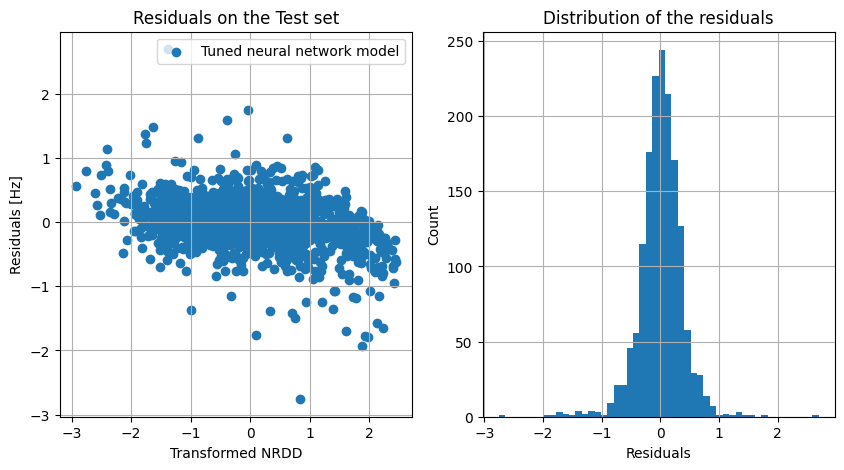

In [21]:
w_pred_tuned_regr = pd.DataFrame(pipe_tuned_network.predict(X_test), index=idx_test)
residuals_regr = w_pred_tuned_regr-w_test

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
plt.scatter(w_test, residuals_regr, label='Tuned neural network model')
plt.xlabel('Transformed NRDD')
plt.ylabel('Residuals [Hz]')
plt.title('Residuals on the Test set')
plt.grid(True)
plt.legend()

ax = fig.add_subplot(1, 2, 2)
plt.hist(residuals_regr, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Distribution of the residuals')
plt.grid(True)
plt.show()

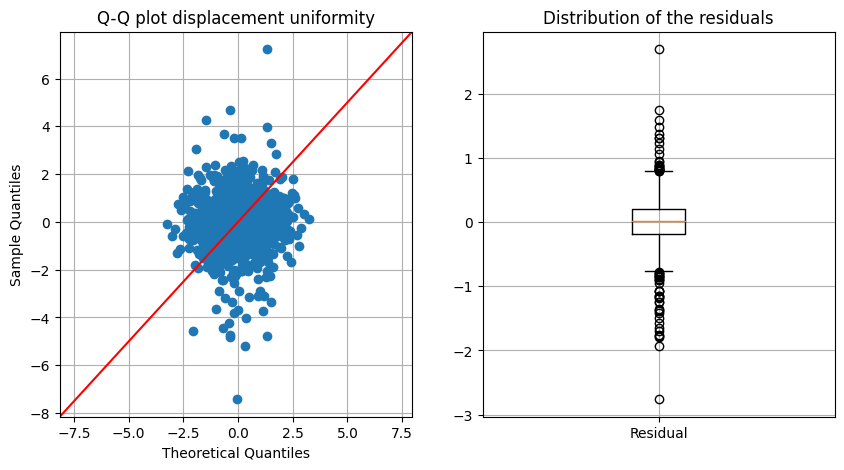

In [37]:
# Distribution of the residuals (transformed target variable)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_regr, fit=True, line='45', ax=ax)
plt.grid(True)
plt.title('Q-Q plot displacement uniformity')

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_regr)
plt.xticks([1], ['Residual'], rotation=0)
plt.xticks([1], ['Residual'], rotation=0)
plt.grid(True)
plt.title('Distribution of the residuals')

plt.show()

* The residuals do not follow a normal law at all
* but are centered around 0

For a better understanding the interpretation will be resumed with the real values (y) of the NRDD, instead of its transformation (w)

In [12]:
# Transform the NRDD predictions and true values back
y_pred_tuned_regr = pd.DataFrame(transf.inverse_transform(w_pred_tuned_regr), index=idx_test)
y_test = pd.DataFrame(transf.inverse_transform(w_test), index=idx_test)
residuals_regr_real = y_pred_tuned_regr-y_test

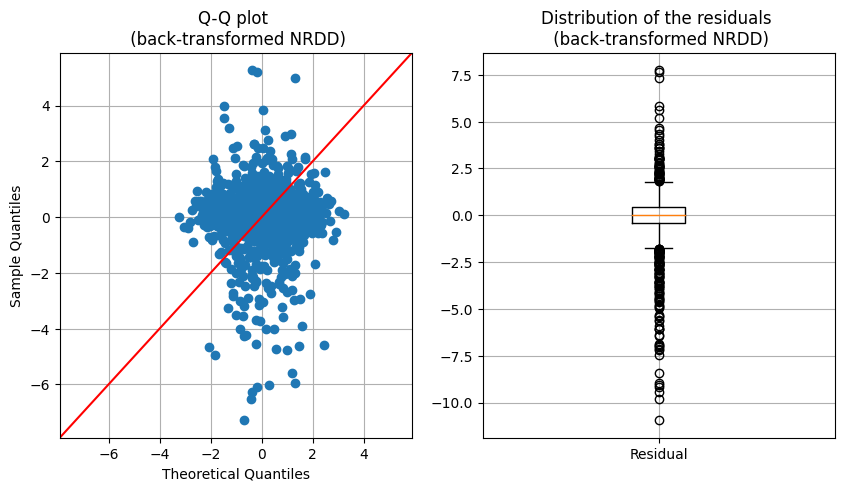

In [36]:
# Distribution of the residuals of the back-transformed target variable

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_regr_real, fit=True, line='45', ax=ax)
plt.grid(True)
plt.title('Q-Q plot \n (back-transformed NRDD)')

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_regr_real)
plt.xticks([1], ['Residual'], rotation=0)
plt.xticks([1], ['Residual'], rotation=0)
plt.title('Distribution of the residuals \n (back-transformed NRDD)')
plt.grid(True)

plt.show()

## Best and worst predictions

The displacements and the corresponding NRDD criterion are calculated for the design points with the best and the worst predictions

In [24]:
# Calculation the absolute values of the residuals
residuals_regr_abs = np.abs(residuals_regr)

# Determination of the indexes of the best and worst predictions
idx_res_max = residuals_regr_abs[0].idxmax()
idx_res_min = residuals_regr_abs[0].idxmin()

Design point with the smallest residual (best prediction)

In [25]:
dp_no_res_min = df_params.loc[idx_res_min, 'dp_no']
mode_no_res_min = df_params.loc[idx_res_min, 'mode_no_long']

print('Design point with the smallest residual:', dp_no_res_min)
print('Number of the long. mode:', mode_no_res_min)

print('Predicted NRDD:', y_pred_tuned_regr.loc[idx_res_min].item())
print('Real NRDD:', y_test.loc[idx_res_min].item())

Design point with the smallest residual: 5131
Number of the long. mode: 67
Predicted NRDD: 3.3086390495300293
Real NRDD: 3.308961221728903


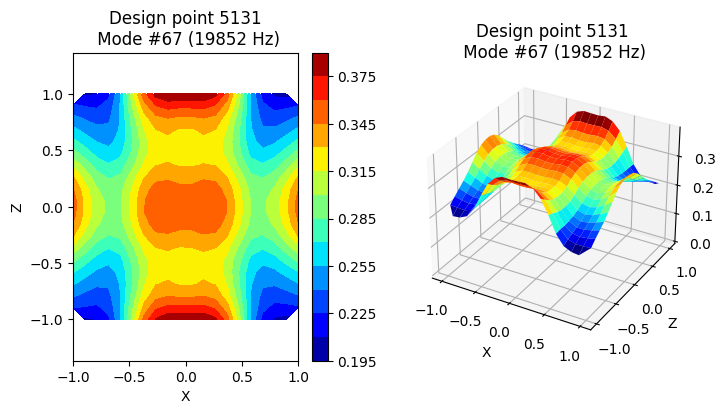

In [26]:
plot_2d_norm_disp(df_modes, df_nodes, df_defs, dp_no_res_min, mode_no_res_min, True);

Design point with the largest residual (worst prediction)

In [27]:
dp_no_res_max = df_params.loc[idx_res_max, 'dp_no']
mode_no_res_max = df_params.loc[idx_res_max, 'mode_no_long']

print('Design point with the largest residual:', dp_no_res_max)
print('Number of the long. mode:', mode_no_res_max)

print('Predicted NRDD:', y_pred_tuned_regr.loc[idx_res_max].item())
print('Real NRDD:', y_test.loc[idx_res_max].item())

Design point with the largest residual: 5961
Number of the long. mode: 66
Predicted NRDD: 2.212930679321289
Real NRDD: 7.846586722192887


In [28]:
# Frequencies: longitudinal mode and neighbour modes below/above
df_params.loc[idx_res_max, ['freq_long', 'freq_delta_below', 'freq_delta_above']]

freq_long           19363.449
freq_delta_below     -486.686
freq_delta_above        1.813
Name: 3956, dtype: object

It stands out that the DP 5961 has a very small value of the feature "freq_delta_above": it means that the next mode has its frequency very close to the longitudinal frequency (only 1.8 Hz!). This is a typical case of a modal interaction causing a mixing of the mode shapes, which becomes obvious when both mode shapes are plotted. The longitudinal mode gets a portion of the displacements of its neighbour, resulting in a poor uniformity of its displacement:

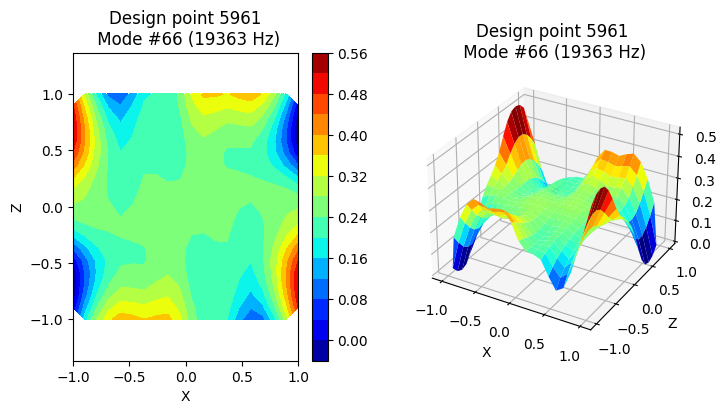

In [29]:
# Representation of the displacement of the longitudinal mode
plot_2d_norm_disp(df_modes, df_nodes, df_defs, dp_no_res_max, mode_no_res_max, True);

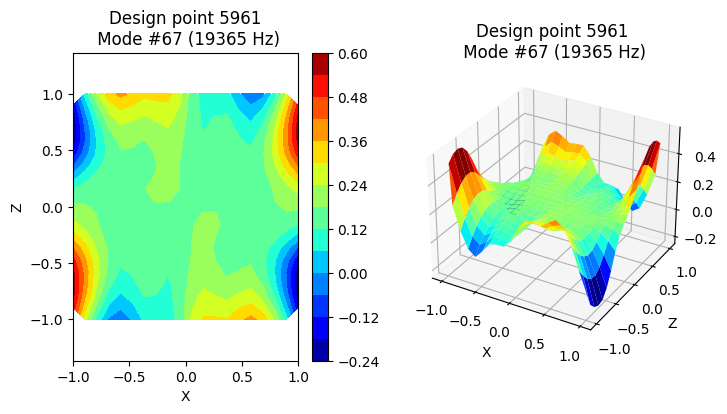

In [30]:
# Representation of the displacement of the next neighbour mode
plot_2d_norm_disp(df_modes, df_nodes, df_defs, dp_no_res_max, mode_no_res_max+1, False);

We introduce a new feature called 'freq_delta_min' as the smallest distance ot the neighbour mode (minimum value between the above and below frequency deltas)

In [31]:
df_params['freq_delta_min'] = df_params.apply(lambda row: min([-row['freq_delta_below'], row['freq_delta_above']]), axis=1)

In [38]:
# Assign the new feature to the test dataset
freq_delta_min_test = df_params.loc[idx_test, 'freq_delta_min']
# Store the existing MAC value
mode_mac_long = df_params.loc[idx_test, 'mode_mac_long']

We want to visualize the quality of the prediction as a function of 1) the vicinity of other modes to the longitudinal modes, 2) the MAC value of the longitudinal mode

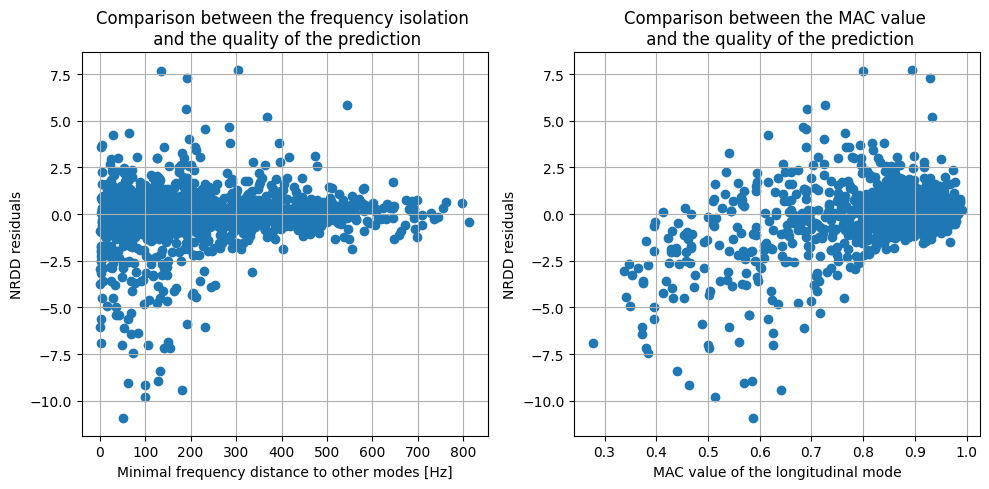

In [41]:
# The residuals are calculated between the real and predicted values of the NRDD (untransformed target variable)
y_residuals_regr = y_pred_tuned_regr-y_test

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
plt.scatter(freq_delta_min_test, y_residuals_regr)
plt.xlabel('Minimal frequency distance to other modes [Hz]')
plt.ylabel('NRDD residuals')
plt.title('Comparison between the frequency isolation \n and the quality of the prediction')
plt.grid(True)

ax = fig.add_subplot(1, 2, 2)
plt.scatter(mode_mac_long, y_residuals_regr)
plt.xlabel('MAC value of the longitudinal mode')
plt.ylabel('NRDD residuals')
plt.title('Comparison between the MAC value \n and the quality of the prediction')
plt.grid(True)

plt.tight_layout()
plt.show()

The residuals are getting smaller when the longitudinal frequency is isolated from other modes and the MAC value is higher. This statement is favorable for the design strategy of the sonotrode: the longitudinal mode has to be as much as possible isolated from other modes, which is part of the objectives.
Under 250 Hz of frequency delta the prediction can be strongly disturbed by the modal interactions.

### Portion of data with a frequency isolation greater than 250 Hz

As for the modelling of the longitudinal frequency, we want to check how big the portion of data is, for which the frequency isolation is big enough.

In [45]:
print('If the threshold for the frequency isolation is set at 250 Hz, ', len(df_params.loc[df_params['freq_delta_min'] > 250])/len(df_params)*100, '% of the data will be kept for the model.')

If the threshold for the frequency isolation is set at 250 Hz,  35.20650813516896 % of the data will be kept for the model.


In [44]:
print('If the threshold for the MAC values is set at 0.8, ', len(df_params.loc[df_params['mode_mac_long'] > 0.8])/len(df_params)*100, '% of the data will be kept for the model.')

If the threshold for the MAC values is set at 0.8,  79.5118898623279 % of the data will be kept for the model.


## SHAP analysis

In [46]:
X100 = shap.utils.sample(X, 100)

In [47]:
explainer = shap.Explainer(pipe_tuned_network.predict, X100)
shap_values = explainer(X100)

PermutationExplainer explainer: 101it [01:30,  1.03it/s]                         


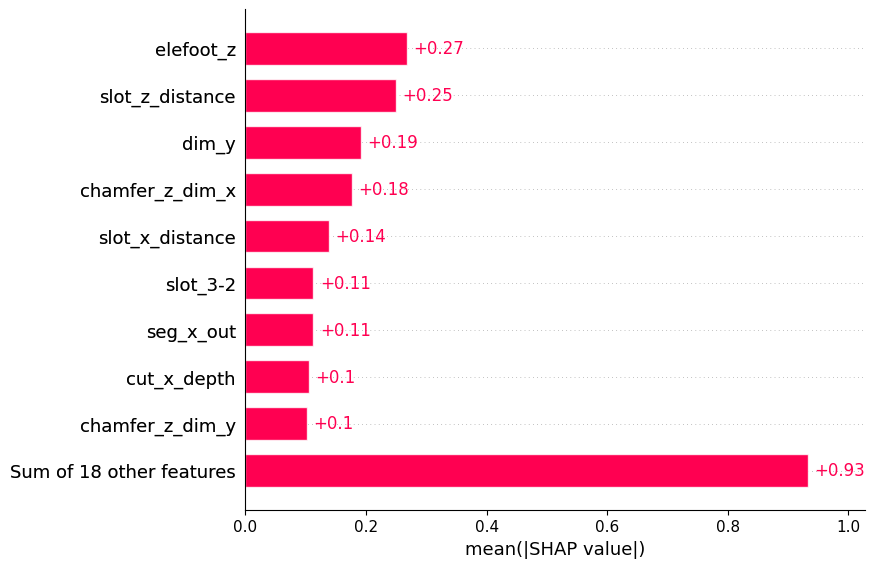

In [48]:
plt.figure(figsize=(4, 4))
shap.plots.bar(shap_values)

Low SHAP values mean that the geometrical parameter improve the uniformity of the output displacement with an important impact

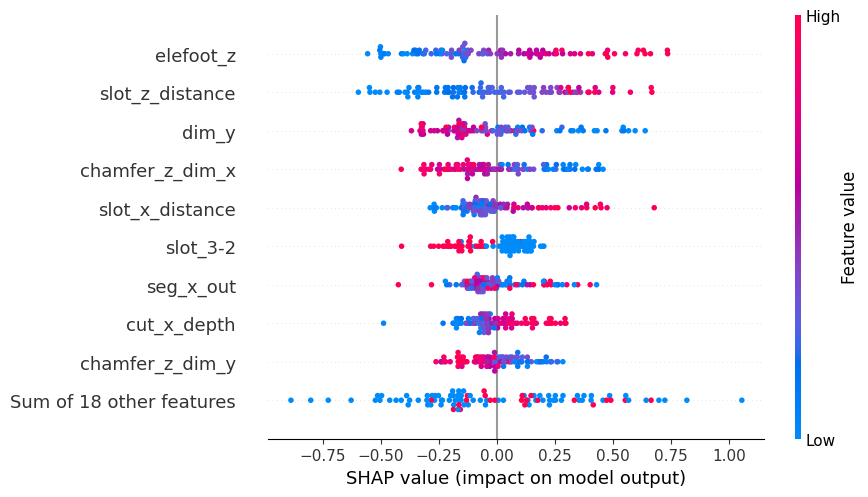

In [49]:
plt.figure(figsize=(4, 4))
shap.plots.beeswarm(shap_values)

* Elefoot in Z direction useless (lowest values give the best uniformity)
* Slot class 3-2 is the best slot distribution for this design: it leads to the best uniformity when active (high value = 1)
